In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
from scipy import sparse
from keras.layers import Dense, Dropout,Flatten,Conv1D,MaxPooling1D
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import glob
import os
#数据导入，并加上标签
target = []
X = None
w = None

files = glob.glob("./BHTdata/*/*.txt")

random.shuffle(files)
SHIFT_LOW_LIMIT = 0
SHIFT_HIGH_LIMIT = 2

for i, f in enumerate(files):
    tmp = pd.read_table(f,sep=',',header=None)
    i_ar_l = np.argwhere(np.array(tmp[0])>=SHIFT_LOW_LIMIT)
    i_ar_l.shape = (i_ar_l.shape[0],)
    i_ar_h = np.argwhere(np.array(tmp[0])<=SHIFT_HIGH_LIMIT)
    i_ar_h.shape = (i_ar_h.shape[0],)
    i_ar = np.array(list(set(i_ar_l) & set(i_ar_h)))
    
    if i == 0:
        tmp1 = tmp[1][i_ar]
        tmp1.index = [i for i in range(0, tmp1.shape[0])]
        X = pd.DataFrame(tmp1).T
        w = np.array(tmp[0][i_ar])
    else:
        tmp1 = tmp[1][i_ar]
        tmp1.index = [i for i in range(0, tmp1.shape[0])]
        X= X.append(tmp1)
    target.append((f.split(os.sep)[-2]))

Using TensorFlow backend.


In [2]:
#检查数据导入情况
X = np.array(X)
target = np.array(target)
classes = np.unique(target)

print(len(files)) 
print(X.shape) 
print(w.shape)
print(target.shape) 
for i, c in enumerate(classes):
    print('classes "{}":  {}'.format(classes[i], sum(target==c)))

250
(250, 500)
(500,)
(250,)
classes "1":  50
classes "12.5":  50
classes "25":  50
classes "37.5":  50
classes "50":  50


In [3]:
#将标记改为浮点数标记
target = np.array(target, dtype=float)
print(target)

[25.  25.   1.  12.5 37.5 37.5 25.  25.  50.  12.5 37.5  1.   1.   1.
  1.  25.  50.  50.   1.  50.  50.  37.5 50.  12.5 50.  12.5 25.  37.5
 37.5 50.  50.   1.  12.5  1.  50.   1.  37.5 25.  12.5 37.5 50.   1.
 50.  25.  50.  37.5 25.  25.   1.  12.5 25.  37.5 37.5 37.5 12.5 37.5
 25.  37.5 12.5 50.  12.5 12.5 25.  25.  25.   1.  12.5  1.  12.5 50.
 12.5 37.5 50.   1.  37.5 37.5 50.  12.5 25.  37.5 50.   1.  12.5  1.
 25.  12.5 12.5  1.  37.5 50.  50.   1.  25.  12.5 25.  50.  12.5 50.
 25.   1.  50.  12.5 25.  50.   1.  37.5 12.5  1.  25.  37.5  1.  50.
 25.  50.  25.  12.5 37.5  1.  25.  25.  12.5 12.5 37.5  1.   1.  37.5
 37.5  1.  12.5 37.5 50.  25.  25.  25.  50.   1.  37.5 37.5 37.5 25.
  1.  50.   1.   1.  12.5  1.  37.5 12.5  1.  25.  37.5 37.5 12.5  1.
  1.  50.  25.  12.5 25.  37.5 25.  25.  37.5 37.5 12.5  1.  50.  50.
 12.5  1.   1.  12.5 12.5  1.   1.  12.5  1.  50.  25.   1.  50.   1.
 25.  50.  37.5 25.  50.  25.  25.  37.5 37.5 12.5 12.5 50.  37.5  1.
 37.5 50.  12.5 2

In [4]:
#加载各种预处理函数
from scipy.fft import fft
def enlarge(arr, factor):
    return np.abs(arr * factor)
from scipy.signal import savgol_filter
def SG(data, w=23, p=7):
    X_s = savgol_filter(data, w, p, mode= 'nearest')
    return X_s
import peakutils
def preprocess(y):
    y_baseline_rm = y - peakutils.baseline(y,deg=1,tol=1e-4)
    return y_baseline_rm

In [5]:
#数据处理
X_raw = np.copy(X)#保留原始数据
X=np.array(X)
for i, x in enumerate(X):
    X[i] = SG(x)  #平滑数据
X=enlarge(X,1000000)
for i, x in enumerate(X):
    X[i] = preprocess(x)#剪基线

#for i, x in enumerate(X):
    #X[i] = fft(x)  
#freq = np.linspace(0, 1/(w[1]-w[0]), len(w)) 
#X = Normalizer().fit_transform(X)  
#归一化

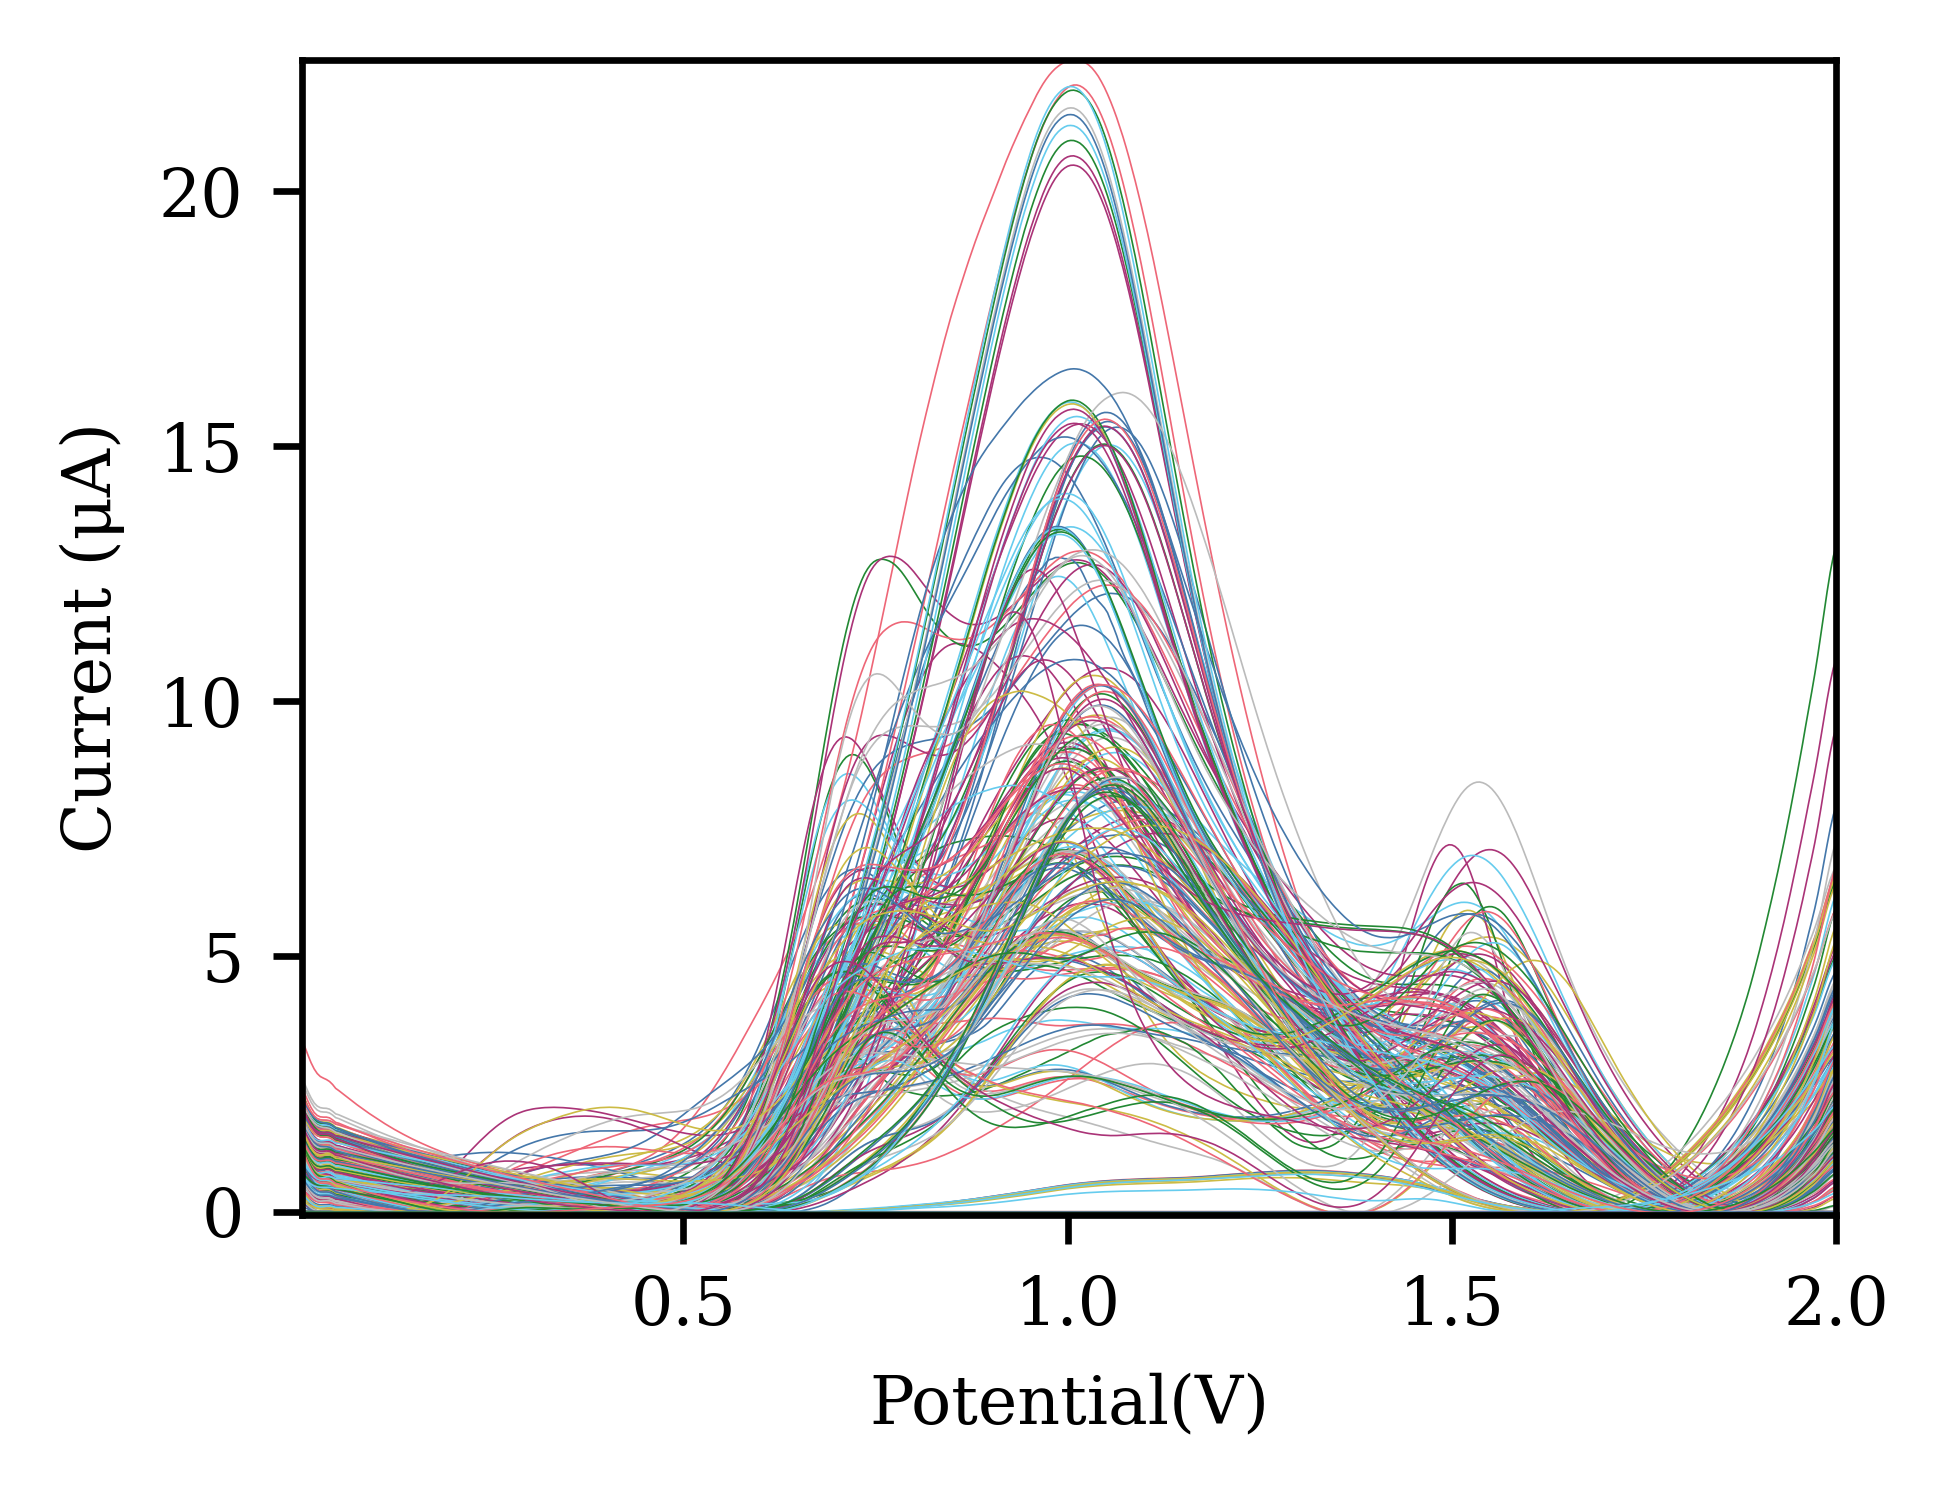

In [6]:
%matplotlib inline
with plt.style.context(['ieee','bright']):
    fig, ax = plt.subplots()
    
    for i, x in enumerate(X):
        ax.plot(w, x, linewidth=0.2)
        ax.plot(w, peakutils.baseline(x,deg=1), linewidth=0.2)
        
    ax.set(xlabel='Potential(V)')
    ax.set(ylabel='Current (μA)')
    ax.autoscale(tight=True)

In [16]:
#给偏最小二乘回归划分训练集和测试集
#split the data to  0.85:0.15
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.15)

print("size of train: {}".format(X_train.shape[0]))
print("size of test: {}".format(X_test.shape[0]))
print(y_test)

size of train: 212
size of test: 38
[12.5 37.5 12.5 12.5 25.  12.5 12.5  1.  50.  50.  50.  25.  12.5  1.
 50.  12.5 50.  37.5 25.  50.  25.  50.   1.   1.  25.   1.  50.  12.5
 12.5 37.5 12.5 50.  25.  25.   1.  50.  50.   1. ]


In [17]:
#pls回归模型、参数
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
pls_model_setup = PLSRegression(scale=True)
param_grid = {'n_components': range(1, 14)}
gsearch = GridSearchCV(pls_model_setup, param_grid)
pls_model = gsearch.fit(X_train, y_train)
score_linear =gsearch.score(X_test,y_test)
print("The score of linear is : %f"%score_linear)
#对测试集做预测
pls_prediction = pls_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pls_prediction))
print("The RMSE score is: %f" % rmse)
for i in range(38):
    print(pls_prediction[i],'--',y_test[i])
    

The score of linear is : 0.958949
The RMSE score is: 3.737124
[14.02499245] -- 12.5
[38.35452868] -- 37.5
[11.21495841] -- 12.5
[15.24156155] -- 12.5
[27.64339116] -- 25.0
[15.11370919] -- 12.5
[13.84254218] -- 12.5
[7.20961092] -- 1.0
[54.43530623] -- 50.0
[51.1573242] -- 50.0
[49.65230422] -- 50.0
[28.30410862] -- 25.0
[14.56092906] -- 12.5
[5.90446139] -- 1.0
[52.90195633] -- 50.0
[15.37958235] -- 12.5
[50.75164817] -- 50.0
[37.02272703] -- 37.5
[27.82011431] -- 25.0
[43.28320051] -- 50.0
[31.84826379] -- 25.0
[49.88728907] -- 50.0
[2.21883441] -- 1.0
[7.01784871] -- 1.0
[29.46089516] -- 25.0
[3.00710276] -- 1.0
[48.07602174] -- 50.0
[15.99720449] -- 12.5
[16.73631935] -- 12.5
[44.72126382] -- 37.5
[18.1707591] -- 12.5
[44.18273856] -- 50.0
[27.9940565] -- 25.0
[30.30417581] -- 25.0
[2.16970884] -- 1.0
[48.12511677] -- 50.0
[48.24818035] -- 50.0
[6.26962605] -- 1.0


In [18]:
#输出PLS的指标
train_score_linear =gsearch.score(X_train,y_train)
print("The trainset score of linear is : %f"%train_score_linear)
test_score_linear =gsearch.score(X_test,y_test)
print("The testset score of linear is : %f"%test_score_linear)
test_prediction = pls_model.predict(X_test)
train_prediction = pls_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_prediction))
print("The train RMSE score is: %f" %train_rmse)
test_rmse = np.sqrt(mean_squared_error(y_test, test_prediction))
print("The test RMSE score is: %f" %test_rmse)

The trainset score of linear is : 0.953508
The testset score of linear is : 0.958949
The train RMSE score is: 3.709097
The test RMSE score is: 3.737124


In [26]:
X_new = X
nb_features = X.shape[1]
nb_class = len(classes)

# split train data into train-valid and test
sss1 = StratifiedShuffleSplit(test_size=0.15, random_state=23)
for train_valid_index, test_index in sss1.split(X_new, target):
    X_train_valid, X_test = X_new[train_valid_index], X_new[test_index]
    y_train_valid, y_test = target[train_valid_index], target[test_index]

sss2 = StratifiedShuffleSplit(test_size=0.15, random_state=23)
for train_index, valid_index in sss2.split(X_train_valid, y_train_valid):
    X_train, X_valid = X_train_valid[train_index], X_train_valid[valid_index]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[valid_index]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

X_train_r = np.expand_dims(X_train, axis=2)
X_valid_r = np.expand_dims(X_valid, axis=2)
X_test_r = np.expand_dims(X_test, axis=2)

print(X_train_r.shape)
print(X_valid_r.shape)
print(X_test_r.shape)

(180, 500)
(32, 500)
(38, 500)
(180, 500, 1)
(32, 500, 1)
(38, 500, 1)


In [27]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
 
from tensorflow.keras.layers import *
from keras import regularizers
from keras import metrics

# 定义一个神经网络
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(500,1),activation='relu'))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(256,kernel_regularizer=regularizers.l1(0.01),bias_regularizer=regularizers.l1(0.01),
activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='linear'))

print(model.summary())
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination,metrics.RootMeanSquaredError(name='rmse')])
 
# 训练模型
nb_epoch = 300
history = model.fit(X_train_r, y_train, epochs=nb_epoch, validation_data=(X_valid_r, y_valid), batch_size=8)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 498, 16)           64        
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 496, 16)           784       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 165, 16)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 163, 64)           3136      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 161, 64)           12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 53, 64)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 51, 16)           

23/23 [==============================] - 0s 9ms/step - loss: 41.4089 - coeff_determination: -128396632.0000 - rmse: 7.5659 - val_loss: 53.4866 - val_coeff_determination: 0.8402 - val_rmse: 7.5316
Epoch 33/300
23/23 [==============================] - 0s 8ms/step - loss: 44.7342 - coeff_determination: 0.8919 - rmse: 7.5030 - val_loss: 52.3243 - val_coeff_determination: 0.8529 - val_rmse: 7.4725
Epoch 34/300
23/23 [==============================] - 0s 8ms/step - loss: 39.3165 - coeff_determination: 0.9179 - rmse: 7.4384 - val_loss: 63.9579 - val_coeff_determination: 0.8334 - val_rmse: 7.4105
Epoch 35/300
23/23 [==============================] - 0s 8ms/step - loss: 43.8979 - coeff_determination: 0.8615 - rmse: 7.3869 - val_loss: 50.8298 - val_coeff_determination: 0.8665 - val_rmse: 7.3563
Epoch 36/300
23/23 [==============================] - 0s 9ms/step - loss: 37.7765 - coeff_determination: 0.9178 - rmse: 7.3249 - val_loss: 54.4037 - val_coeff_determination: 0.8378 - val_rmse: 7.2948
Epoc

Epoch 73/300
23/23 [==============================] - 0s 7ms/step - loss: 25.8844 - coeff_determination: 0.9485 - rmse: 6.0637 - val_loss: 41.4063 - val_coeff_determination: 0.8924 - val_rmse: 6.0528
Epoch 74/300
23/23 [==============================] - 0s 7ms/step - loss: 28.5883 - coeff_determination: 0.9321 - rmse: 6.0415 - val_loss: 47.0771 - val_coeff_determination: 0.8754 - val_rmse: 6.0312
Epoch 75/300
23/23 [==============================] - 0s 7ms/step - loss: 28.2659 - coeff_determination: 0.9284 - rmse: 6.0197 - val_loss: 47.7969 - val_coeff_determination: 0.8698 - val_rmse: 6.0104
Epoch 76/300
23/23 [==============================] - 0s 7ms/step - loss: 27.0250 - coeff_determination: 0.9311 - rmse: 5.9992 - val_loss: 44.7627 - val_coeff_determination: 0.8800 - val_rmse: 5.9886
Epoch 77/300
23/23 [==============================] - 0s 7ms/step - loss: 25.9672 - coeff_determination: 0.9317 - rmse: 5.9759 - val_loss: 41.9256 - val_coeff_determination: 0.8911 - val_rmse: 5.9659


Epoch 114/300
23/23 [==============================] - 0s 7ms/step - loss: 19.7058 - coeff_determination: 0.9668 - rmse: 5.3972 - val_loss: 43.0978 - val_coeff_determination: 0.8685 - val_rmse: 5.3912
Epoch 115/300
23/23 [==============================] - 0s 7ms/step - loss: 19.5031 - coeff_determination: 0.9583 - rmse: 5.3835 - val_loss: 43.3753 - val_coeff_determination: 0.8702 - val_rmse: 5.3777
Epoch 116/300
23/23 [==============================] - 0s 7ms/step - loss: 19.3637 - coeff_determination: 0.9619 - rmse: 5.3700 - val_loss: 48.0731 - val_coeff_determination: 0.8437 - val_rmse: 5.3646
Epoch 117/300
23/23 [==============================] - 0s 7ms/step - loss: 21.3614 - coeff_determination: 0.9296 - rmse: 5.3578 - val_loss: 42.9345 - val_coeff_determination: 0.8872 - val_rmse: 5.3531
Epoch 118/300
23/23 [==============================] - 0s 7ms/step - loss: 23.2214 - coeff_determination: 0.9484 - rmse: 5.3479 - val_loss: 44.1557 - val_coeff_determination: 0.8635 - val_rmse: 5.

Epoch 155/300
23/23 [==============================] - 0s 8ms/step - loss: 15.9628 - coeff_determination: 0.9658 - rmse: 4.9451 - val_loss: 31.2569 - val_coeff_determination: 0.9112 - val_rmse: 4.9407
Epoch 156/300
23/23 [==============================] - 0s 7ms/step - loss: 15.7621 - coeff_determination: 0.9679 - rmse: 4.9353 - val_loss: 29.2317 - val_coeff_determination: 0.9210 - val_rmse: 4.9308
Epoch 157/300
23/23 [==============================] - 0s 7ms/step - loss: 13.8862 - coeff_determination: 0.9803 - rmse: 4.9247 - val_loss: 33.0999 - val_coeff_determination: 0.9012 - val_rmse: 4.9203
Epoch 158/300
23/23 [==============================] - 0s 7ms/step - loss: 15.2473 - coeff_determination: 0.9616 - rmse: 4.9147 - val_loss: 33.5407 - val_coeff_determination: 0.9005 - val_rmse: 4.9107
Epoch 159/300
23/23 [==============================] - 0s 7ms/step - loss: 16.0695 - coeff_determination: 0.9687 - rmse: 4.9061 - val_loss: 31.0506 - val_coeff_determination: 0.9166 - val_rmse: 4.

Epoch 196/300
23/23 [==============================] - 0s 7ms/step - loss: 11.8096 - coeff_determination: 0.9801 - rmse: 4.5946 - val_loss: 24.5964 - val_coeff_determination: 0.9298 - val_rmse: 4.5910
Epoch 197/300
23/23 [==============================] - 0s 7ms/step - loss: 10.3655 - coeff_determination: 0.9841 - rmse: 4.5864 - val_loss: 27.2365 - val_coeff_determination: 0.9149 - val_rmse: 4.5826
Epoch 198/300
23/23 [==============================] - 0s 7ms/step - loss: 10.4457 - coeff_determination: 0.9845 - rmse: 4.5780 - val_loss: 25.9722 - val_coeff_determination: 0.9249 - val_rmse: 4.5743
Epoch 199/300
23/23 [==============================] - 0s 8ms/step - loss: 10.7278 - coeff_determination: 0.9828 - rmse: 4.5699 - val_loss: 27.0025 - val_coeff_determination: 0.9166 - val_rmse: 4.5663
Epoch 200/300
23/23 [==============================] - 0s 7ms/step - loss: 12.0246 - coeff_determination: 0.9797 - rmse: 4.5621 - val_loss: 31.5674 - val_coeff_determination: 0.9009 - val_rmse: 4.

Epoch 237/300
23/23 [==============================] - 0s 7ms/step - loss: 10.0070 - coeff_determination: 0.9823 - rmse: 4.3290 - val_loss: 23.3107 - val_coeff_determination: 0.9315 - val_rmse: 4.3262
Epoch 238/300
23/23 [==============================] - 0s 8ms/step - loss: 10.5135 - coeff_determination: 0.9733 - rmse: 4.3229 - val_loss: 24.4282 - val_coeff_determination: 0.9246 - val_rmse: 4.3204
Epoch 239/300
23/23 [==============================] - 0s 8ms/step - loss: 9.1141 - coeff_determination: 0.9853 - rmse: 4.3170 - val_loss: 22.1163 - val_coeff_determination: 0.9340 - val_rmse: 4.3140
Epoch 240/300
23/23 [==============================] - 0s 8ms/step - loss: 8.3081 - coeff_determination: 0.9866 - rmse: 4.3103 - val_loss: 23.7946 - val_coeff_determination: 0.9253 - val_rmse: 4.3074
Epoch 241/300
23/23 [==============================] - 0s 7ms/step - loss: 8.5290 - coeff_determination: 0.9858 - rmse: 4.3038 - val_loss: 22.6840 - val_coeff_determination: 0.9339 - val_rmse: 4.300

Epoch 278/300
23/23 [==============================] - 0s 7ms/step - loss: 8.6690 - coeff_determination: 0.9853 - rmse: 4.1036 - val_loss: 24.8018 - val_coeff_determination: 0.9186 - val_rmse: 4.1016
Epoch 279/300
23/23 [==============================] - 0s 7ms/step - loss: 8.6739 - coeff_determination: 0.9827 - rmse: 4.0988 - val_loss: 25.3521 - val_coeff_determination: 0.9208 - val_rmse: 4.0971
Epoch 280/300
23/23 [==============================] - 0s 8ms/step - loss: 9.5905 - coeff_determination: 0.9757 - rmse: 4.0948 - val_loss: 24.2582 - val_coeff_determination: 0.9146 - val_rmse: 4.0928
Epoch 281/300
23/23 [==============================] - 0s 8ms/step - loss: 10.4013 - coeff_determination: 0.9759 - rmse: 4.0908 - val_loss: 24.8559 - val_coeff_determination: 0.9182 - val_rmse: 4.0890
Epoch 282/300
23/23 [==============================] - 0s 7ms/step - loss: 7.8670 - coeff_determination: 0.9849 - rmse: 4.0863 - val_loss: 25.7141 - val_coeff_determination: 0.9171 - val_rmse: 4.0843

In [28]:
scores = model.evaluate(X_train_r,y_train)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
scores = model.evaluate(X_test_r,y_test)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
scores = model.evaluate(X_valid_r,y_valid)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))

6/6 [==============================] - 0s 5ms/step - loss: 5.6733 - coeff_determination: 0.9945 - rmse: 3.9968
coeff_determination: 99.45%
2/2 [==============================] - 0s 1ms/step - loss: 11.0026 - coeff_determination: 0.9797 - rmse: 3.9942
coeff_determination: 97.97%
1/1 [==============================] - 0s 1ms/step - loss: 21.0782 - coeff_determination: 0.9413 - rmse: 3.9942
coeff_determination: 94.13%


In [30]:
prediction=model.predict(X_test_r)
for i in range(38):
    print(prediction[i],'--',y_test[i])
   

[2.1097074] -- 1.0
[51.924503] -- 50.0
[48.964188] -- 50.0
[1.9717915] -- 1.0
[16.694586] -- 12.5
[47.97501] -- 50.0
[26.219818] -- 25.0
[1.0876818] -- 1.0
[24.588377] -- 25.0
[45.43498] -- 37.5
[38.09281] -- 37.5
[10.743066] -- 12.5
[37.847652] -- 37.5
[0.03203328] -- 1.0
[37.818684] -- 37.5
[14.932023] -- 12.5
[0.49340063] -- 1.0
[13.324722] -- 12.5
[0.7983711] -- 1.0
[1.3658221] -- 1.0
[12.36947] -- 12.5
[10.244357] -- 12.5
[35.933834] -- 37.5
[16.954721] -- 12.5
[21.967121] -- 25.0
[45.63407] -- 50.0
[44.880787] -- 50.0
[40.246937] -- 37.5
[19.327389] -- 25.0
[23.926136] -- 25.0
[15.6388] -- 12.5
[49.695435] -- 50.0
[49.49394] -- 50.0
[46.730324] -- 50.0
[22.679539] -- 25.0
[0.36954927] -- 1.0
[26.86772] -- 25.0
[36.548615] -- 37.5
